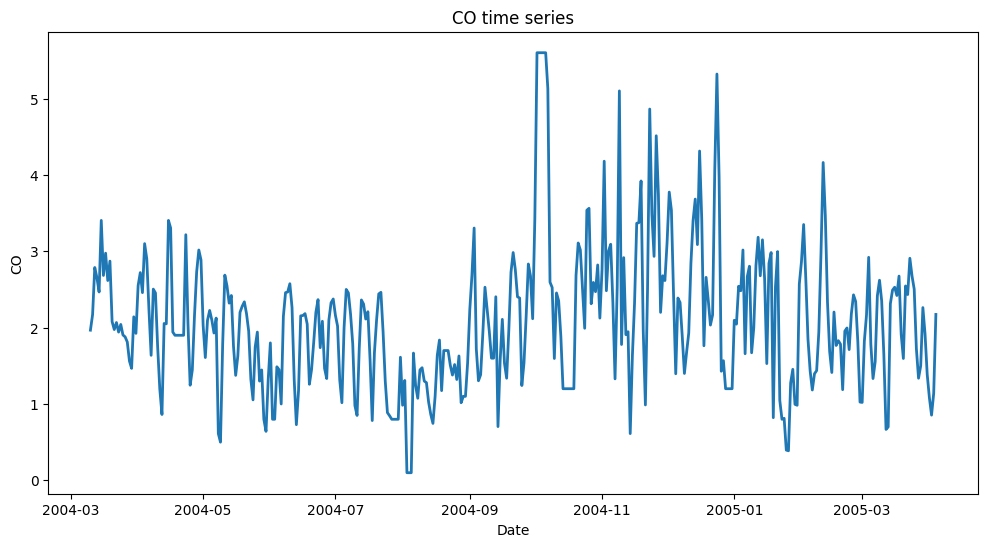

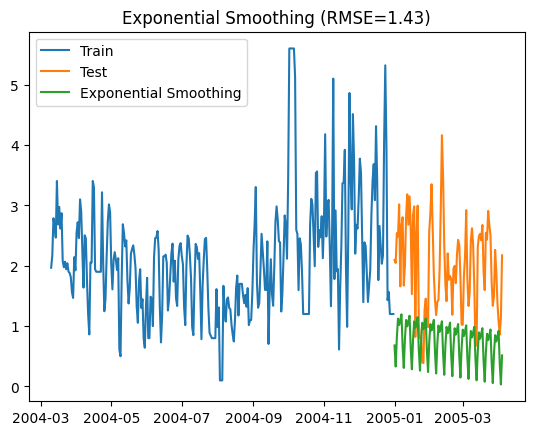

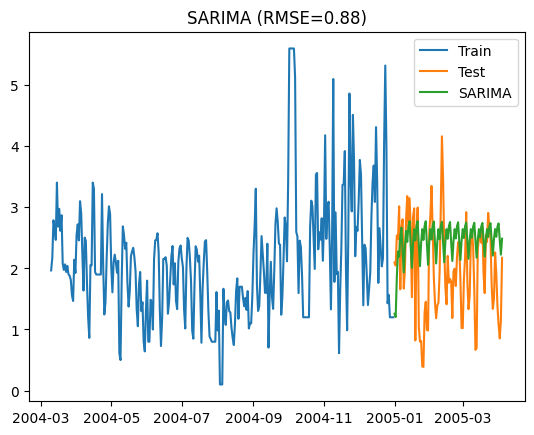

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing
import pmdarima as pm
from pmdarima.arima import auto_arima

# загрузка данных
data = pd.read_csv('AirQuality.csv', sep=';', decimal=',', na_values='-200')
data.head(5)
# удаление ненужных столбцов
data = data[['Date', 'Time', 'CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']]

# переименование колонок
data = data.rename(columns={'Date': 'date', 'Time': 'time', 'CO(GT)': 'CO'})

# объединение колонок date и time в колонку datetime
data['datetime'] = pd.to_datetime(data['date'] + ' ' + data['time'], format='%d/%m/%Y %H.%M.%S')

# приведение типов колонок к числовому формату
data[['CO', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']] = data[['CO', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']].apply(pd.to_numeric, errors='coerce')

# удаление ненужных колонок
data.drop(['date', 'time'], axis=1, inplace=True)


# очистка данных
data.fillna(method='ffill', inplace=True)

# преобразование колонки datetime в индекс
data.set_index('datetime', inplace=True)

# ресемплирование данных по дням и вычисление средних значений
daily_data = data.resample('D').mean()

# визуализация временного ряда и его основных характеристик
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_data['CO'], linewidth=2)
plt.title('CO time series')
plt.xlabel('Date')
plt.ylabel('CO')
plt.show()

# разделение данных на обучающую и тестовую выборки
train = daily_data[:'2004-12-31']
test = daily_data['2005-01-01':]

# обучение модели ExponentialSmoothing
model = ExponentialSmoothing(train['CO'], trend='add', seasonal='add', seasonal_periods=7)
fit = model.fit()

# прогнозирование значений на тестовой выборке
pred = fit.forecast(len(test))

# вычисление среднеквадратичной ошибки (RMSE)
rmse = np.sqrt(mean_squared_error(test['CO'], pred))

# отображение результатов прогнозирования на графике
plt.plot(train['CO'], label='Train')
plt.plot(test['CO'], label='Test')
plt.plot(pred, label='Exponential Smoothing')
plt.legend(loc='best')
plt.title(f'Exponential Smoothing (RMSE={rmse:.2f})')
plt.show()

# обучение модели SARIMA
model_sarima = auto_arima(train['CO'], seasonal=True, m=7)
fit_sarima = model_sarima.fit(train['CO'])

# прогнозирование значений на тестовой выборке
pred_sarima = fit_sarima.predict(len(test))

# вычисление среднеквадратичной ошибки (RMSE)
rmse_sarima = np.sqrt(mean_squared_error(test['CO'], pred_sarima))

# отображение результатов прогнозирования на графике
plt.plot(train['CO'], label='Train')
plt.plot(test['CO'], label='Test')
plt.plot(pred_sarima, label='SARIMA')
plt.legend(loc='best')
plt.title(f'SARIMA (RMSE={rmse_sarima:.2f})')
plt.show()

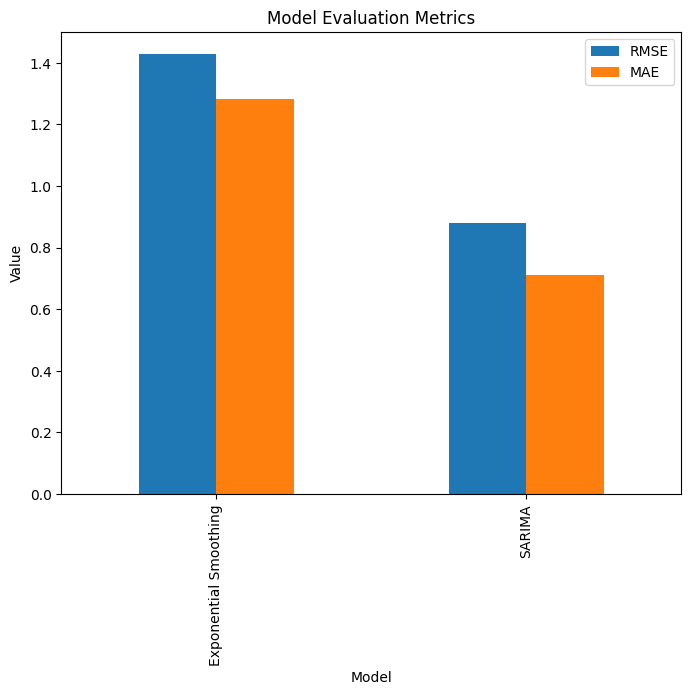

In [2]:
# вычисление метрик RMSE и MAE для модели Exponential Smoothing
rmse_es = np.sqrt(mean_squared_error(test['CO'], pred))
mae_es = np.mean(np.abs(test['CO'] - pred))

# вычисление метрик RMSE и MAE для модели SARIMA
rmse_sarima = np.sqrt(mean_squared_error(test['CO'], pred_sarima))
mae_sarima = np.mean(np.abs(test['CO'] - pred_sarima))

# визуализация метрик RMSE и MAE
fig, ax = plt.subplots(figsize=(8, 6))
metrics = pd.DataFrame({'Model': ['Exponential Smoothing', 'SARIMA'], 'RMSE': [rmse_es, rmse_sarima], 'MAE': [mae_es, mae_sarima]})
metrics = metrics.set_index('Model')
metrics.plot(kind='bar', ax=ax)
plt.title('Model Evaluation Metrics')
plt.xlabel('Model')
plt.ylabel('Value')
plt.show()